In [29]:
%load_ext autoreload
%autoreload 2 

import sys
sys.path.insert(0, "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/")
import hyperiax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey

from scipy.spatial import procrustes

from hyperiax.tree.topology import read_topology
from hyperiax.pca.pca import PhylogeneticPCA, PCA
from hyperiax.pca.phylo_matrices import PhylogenicCovarianceMatrices
from hyperiax.plotting import plot_tree, plot_tree_text, plot_shape_2d, plot_tree_3d_scatter, plot_tree_2d_scatter
from hyperiax.pca.gls_reconstuction import estimate_grand_mean, estimate_inner_nodes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
seed = 42
key = PRNGKey(seed)

# Phylogenetic PCA on an evolutionary tree

In this notebook, we illutrate how to perform phylogenetic PCA on a HypTree with landmark data contained in the leaf nodes. 
We also estimate inner nodes and plot the tree by projecting it into shape-space 
The method is based on the following articles: 
Phylogenetic Principal Components Analysis and Geometric Morphometrics by P.D. Polly et. al. (2013) 
Phylogenies and the Comparative Method: A General Approach to Incorporating Phylogenetic Information into the Analysis of Interspecific Data by E.P. Hansen & T.F. Hansen (1997).

The tree is exported for further visualization.

The steps are:
- Load a tree with branch lengths and landmark leaf data 
- Perform Procrustes superimposition on the leaf data
- Compute phylogenetic covariance matrices
- Perform ancestral state reconstruction to estimate root and inner nodes landmark data
- Insert estimated inner nodes and root node in tree
- Perform regular PCA, compute explained variance and plot scores
- Perform phylogenetic PCA and compute explained variance
- Project tip data and estimated data into the phylogenetic shape-space
- Plot the scores in shape-space
- Use the principal components to visualize non-phylogenetic shape change
- Export the tree using Pickle

# Load tree

HypTree(size=33, levels=7, leaves=17, inner nodes=15)
                                                                                                                                   
                                                                                                                                   
                                     ┌────────────────────────────────────────────────────────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────┐
                                    None                                                                                                                                                                                       None                                                      
      ┌──────────────────────────────┴───────────────────────────────┐                                                                                                        

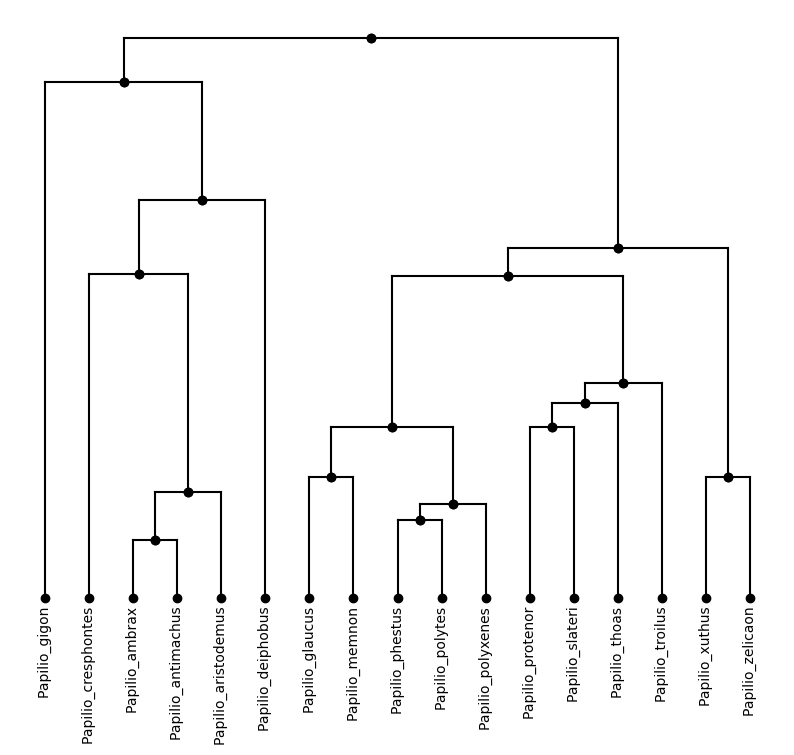

In [31]:
# data and landmarks dimensions
d=2

filename = "../data/butterflies/papilio_male_dataset/papilio_tree.tree"
filename_csv = "../data/butterflies/papilio_male_dataset/papilio_shapes.csv"
#filename = "../data/butterflies/male_dataset/species_tree.tre"
#filename_csv = "../data/butterflies/male_dataset/landmarks.csv"
with open(filename, "r") as file:
    string_tree = file.read()
tree = read_topology(string_tree)
# print the tree
print(tree)
plot_tree_text(tree)
plot_tree(tree,inc_names=True)

# Load tree with landmark data

n landmarks:  118
n landmarks after removing coinciding landmarks:  (33, 234)


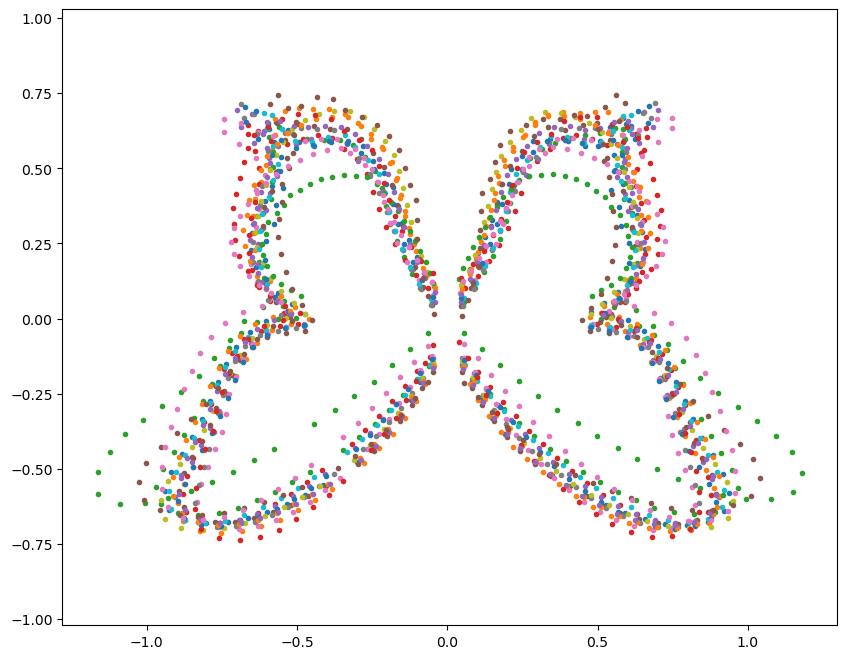

In [32]:

# load landmarks into tree

n_steps = 25

if not filename.__contains__('papilio'):
    landmarks = pd.read_csv(filename_csv, sep=",", header = 0)
    node_names= [ node.name for node in list(tree.iter_topology_bfs())]
    # Set the species column as the index before reindexing
    landmarks = landmarks.set_index('species')
    landmarks = landmarks.reindex(node_names[0:])
    # Remove the column with edges
    landmarks = landmarks.drop(columns="count")    
    landmarks = landmarks.to_numpy()
else: 
    landmarks_edges = pd.read_csv(filename_csv, sep=",", header = 0)
    node_names = landmarks_edges['node_names'] 
    landmarks_edges = landmarks_edges.set_index('node_names')
    landmarks = landmarks_edges.drop(columns="edges")
    landmarks = landmarks.to_numpy()

# Check for NaN values in landmarks array
nan_rows = jnp.where(jnp.isnan(landmarks).any(axis=1))[0]
if len(nan_rows) > 0:
    print("Warning: NaN values found in landmarks array at row(s):", nan_rows)
n = landmarks.shape[1]//d
print("n landmarks: ",n)
landmarks = landmarks.reshape((-1,n,d))
landmarks = jnp.delete(landmarks,66,axis=1) # drop row with coinciding landmarks
landmarks = landmarks.reshape((landmarks.shape[0],-1))
n = landmarks.shape[1]//d
print("n landmarks after removing coinciding landmarks: ",landmarks.shape)

# scale landmarks
n_shapes = landmarks.shape[0]
landmarks = 2*1e-3*landmarks.reshape((n_shapes,-1,d))[:,::1].reshape((n_shapes,-1))

# add landmarks to tree 
tree.add_property('value', shape=(n_steps+1,n*d,))
tree.data['value'] = tree.data['value'].at[:].set(landmarks[:,None,:])
leaf_values = tree.data['value'][tree.is_leaf][:,-1]

# plot landmarks
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)
       
if filename.__contains__('papilio'):
    for i,node in enumerate(tree.iter_topology_bfs()):
        node.name = node_names[i]

# Procrustes superimposition on leaf landmarks 

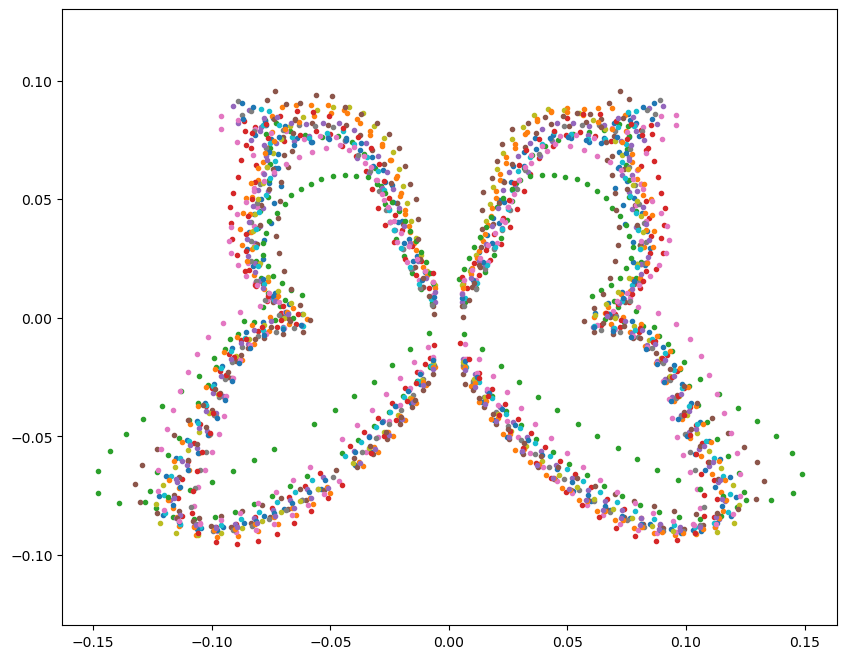

In [33]:
# Procrustes superimposition on leaves
n_coords = leaf_values.shape[1]
n_landmarks = n_coords // 2  

# Reshape to 2D shapes: (n_shapes, n_landmarks, 2)
leaves2d = leaf_values.reshape((-1, n_landmarks, 2))

# Align to first leaf
reference_shape = leaves2d[0]

aligned_leaves = []

for shape in leaves2d:
    _, aligned_shape, _ = procrustes(reference_shape, shape)
    aligned_leaves.append(aligned_shape)
    
# Reshape aligned leaves, so we can put them back into the tree
aligned_leaves = np.array(aligned_leaves)

aligned_leaves_flat = aligned_leaves.reshape((aligned_leaves.shape[0], n_coords))

reshaped_leaves = np.full((aligned_leaves_flat.shape[0], n_steps+1, n_coords), np.nan)
reshaped_leaves[:, -1, :] = aligned_leaves_flat

# Insert the procrustes aligned leaves into the tree
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(reshaped_leaves)

leaf_values = tree.data['value'][tree.is_leaf][:,-1]

# Plot tree again to check how the landmarks look
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)

# Compute phylogenetic matrices

In [34]:
phylo_matrices = PhylogenicCovarianceMatrices(tree)
C_Y, C_A, C_AY = phylo_matrices.get_covariance_matrices()

# Estimate ancestral states

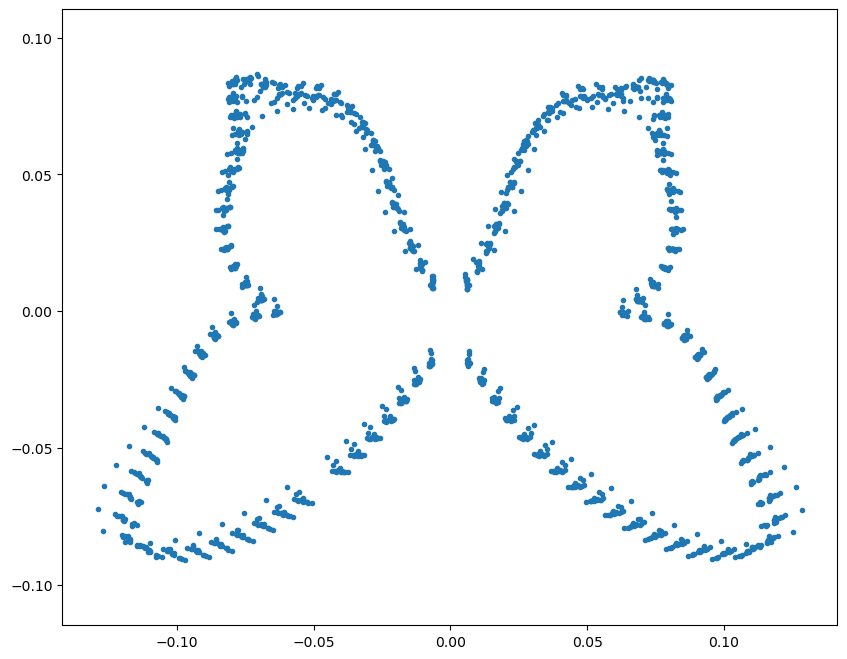

In [35]:
estimated_root = estimate_grand_mean(C_Y, leaf_values)
estimated_inner = estimate_inner_nodes(estimated_root, C_AY, C_Y, leaf_values)

fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(estimated_inner,ax=ax)

# Insert estimated inner nodes and root in tree

In [36]:
aligned_root_flat = estimated_root.reshape((n_landmarks * 2,))
reshaped_root = np.full((1, n_steps+1, n_coords), np.nan)
reshaped_root[0, -1, :] = aligned_root_flat  

tree.data['value'] = tree.data['value'].at[tree.is_root].set(reshaped_root)
a = tree.data['value'][tree.is_root][:,-1]

n_inner_nodes = estimated_inner.shape[0]
aligned_inner_flat = estimated_inner.reshape((n_inner_nodes, n_coords))
reshaped_estimates = np.full((n_inner_nodes, n_steps+1, n_coords), np.nan)
reshaped_estimates[:, -1, :] = aligned_inner_flat

tree.data['value'] = tree.data['value'].at[tree.is_inner].set(reshaped_estimates)
estimated_inner = tree.data['value'][tree.is_inner][:,-1]

# Regular PCA

     PC  Explained Variance (%)
0   PC1                   62.10
1   PC2                   18.48
2   PC3                   12.44
3   PC4                    2.90
4   PC5                    1.64
5   PC6                    0.82
6   PC7                    0.44
7   PC8                    0.35
8   PC9                    0.21
9  PC10                    0.19
     PC  Cumulative Variance (%)
0   PC1                    62.10
1   PC2                    80.58
2   PC3                    93.02
3   PC4                    95.92
4   PC5                    97.55
5   PC6                    98.38
6   PC7                    98.82
7   PC8                    99.17
8   PC9                    99.38
9  PC10                    99.57


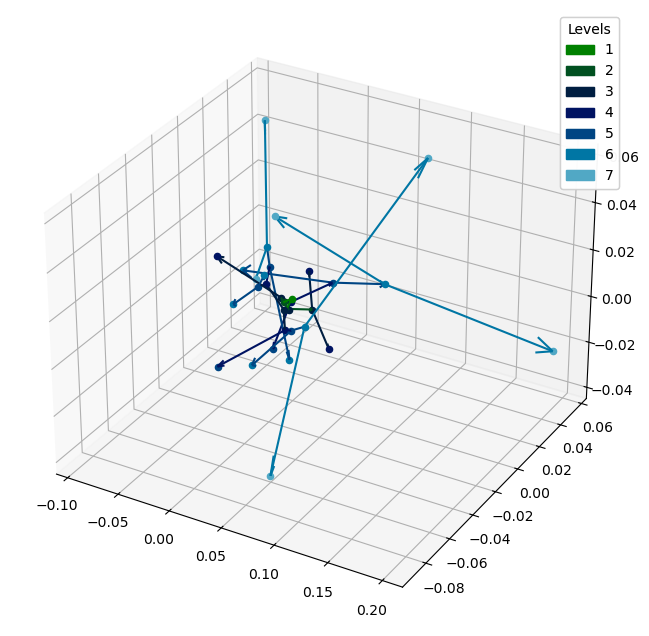

In [37]:
pca = PCA()
U, S = pca.fit(leaf_values)

pca.get_explained_variance()
pca.get_cumulative_variance()

# Transform data
features_leaves, features_inner = pca.transform(leaf_values, estimated_inner, 3)

# Insert transformed data into tree
tree.add_property('projected_value', shape=(3,))
    
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_leaf].set(features_leaves)
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_inner].set(features_inner)

plot_tree_3d_scatter(tree, 'projected_value')

# Perform phylogenetic PCA

     PC  Explained Variance (%)
0   PC1                   68.43
1   PC2                   15.81
2   PC3                   11.12
3   PC4                    2.41
4   PC5                    0.80
5   PC6                    0.62
6   PC7                    0.24
7   PC8                    0.19
8   PC9                    0.17
9  PC10                    0.09
     PC  Cumulative Variance (%)
0   PC1                    68.43
1   PC2                    84.24
2   PC3                    95.35
3   PC4                    97.76
4   PC5                    98.56
5   PC6                    99.17
6   PC7                    99.41
7   PC8                    99.60
8   PC9                    99.77
9  PC10                    99.85


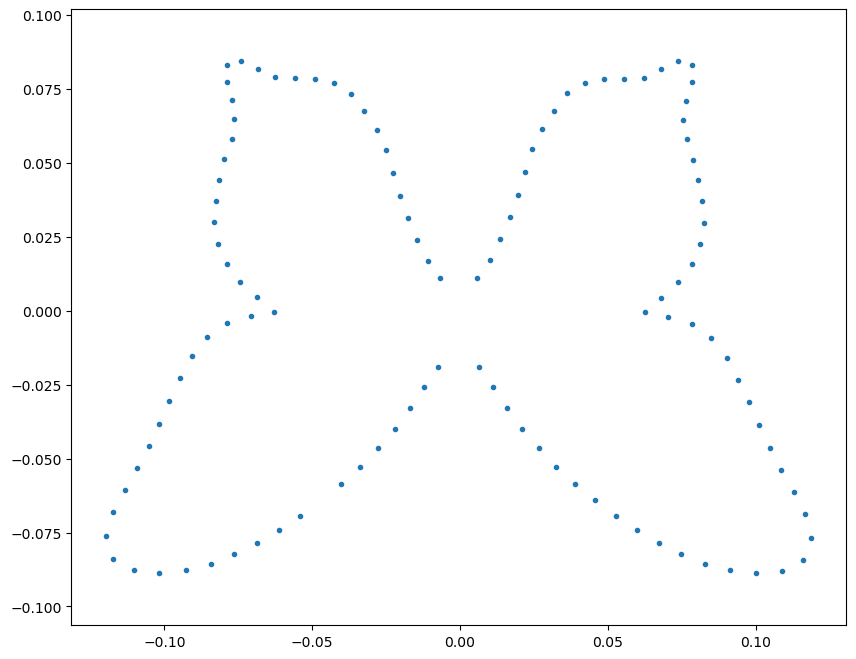

In [38]:
## Warning:
## The proportion of explained variance does not reflect the original trait variance 
## unless a compatible phenotypic unit is used for the branch lengths used to compute C

ppca = PhylogeneticPCA()
Up, Sp = ppca.fit(estimated_root, C_Y, leaf_values)

ppca.get_explained_variance()
ppca.get_cumulative_variance()

fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(estimated_root,ax=ax)

# Project tree into shape space

In [39]:
# Transform data
features_leaves, features_inner = ppca.transform(leaf_values, estimated_inner, 3)

# Insert transformed data into tree
tree.add_property('projected_value', shape=(3,))
    
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_leaf].set(features_leaves)
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_inner].set(features_inner)


# Plot scores

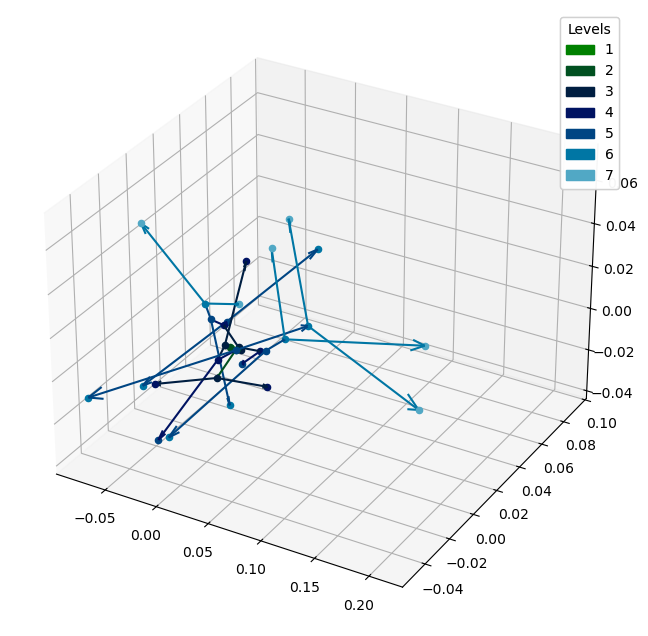

In [40]:
plot_tree_3d_scatter(tree, 'projected_value')

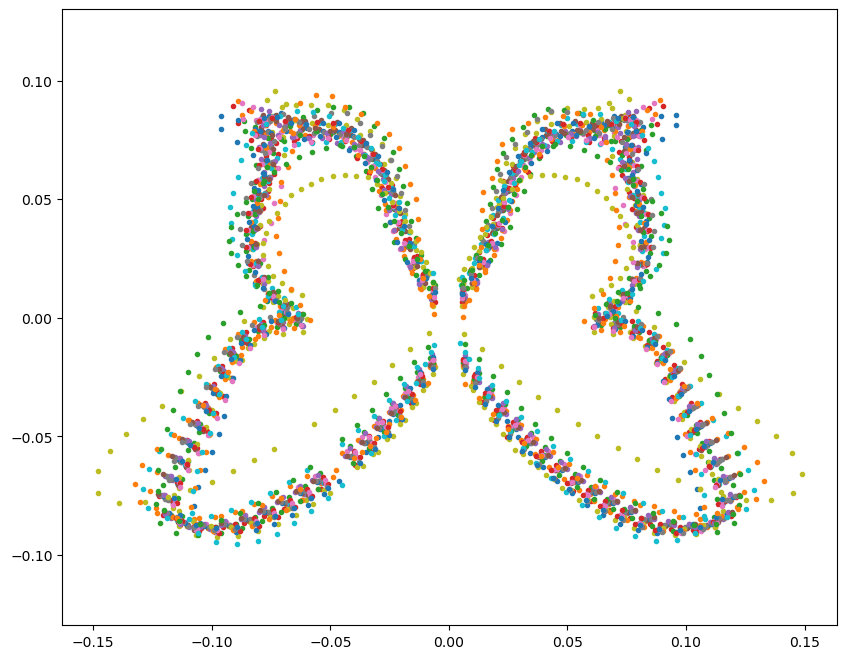

In [41]:
# Check that estimated landmarks are aligned

fig,ax = plt.subplots(figsize=(10,8))
for node in tree.iter_topology_bfs():
    plot_shape_2d(tree.data['value'][node.id][-1],ax=ax)

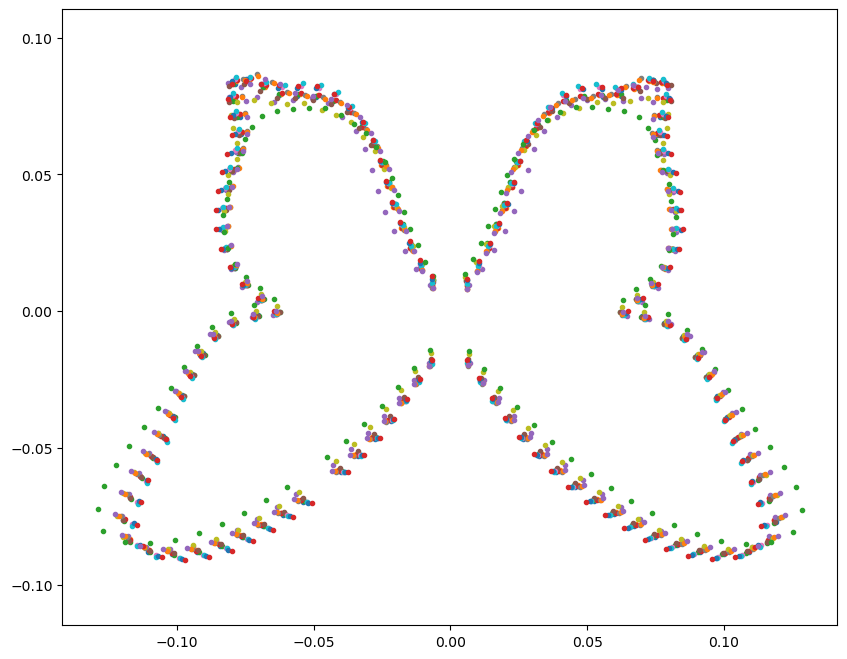

In [42]:
# Inner nodes

fig,ax = plt.subplots(figsize=(10,8))
for node in tree.iter_topology_inner_nodes_bfs():
    plot_shape_2d(tree.data['value'][node.id][-1],ax=ax)

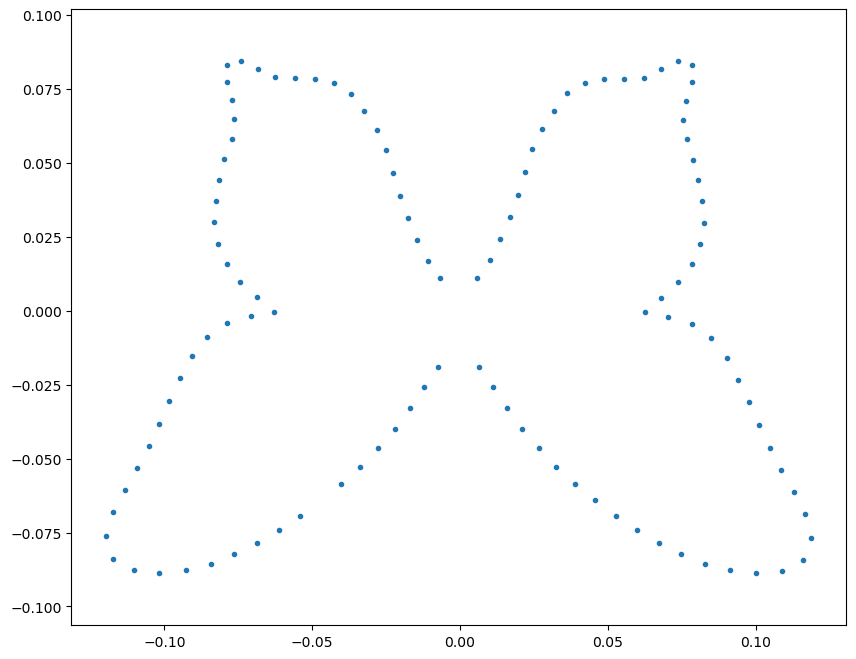

In [43]:
# Root node

fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(a,ax=ax)

# Visualize non-phylogenetic shape variation

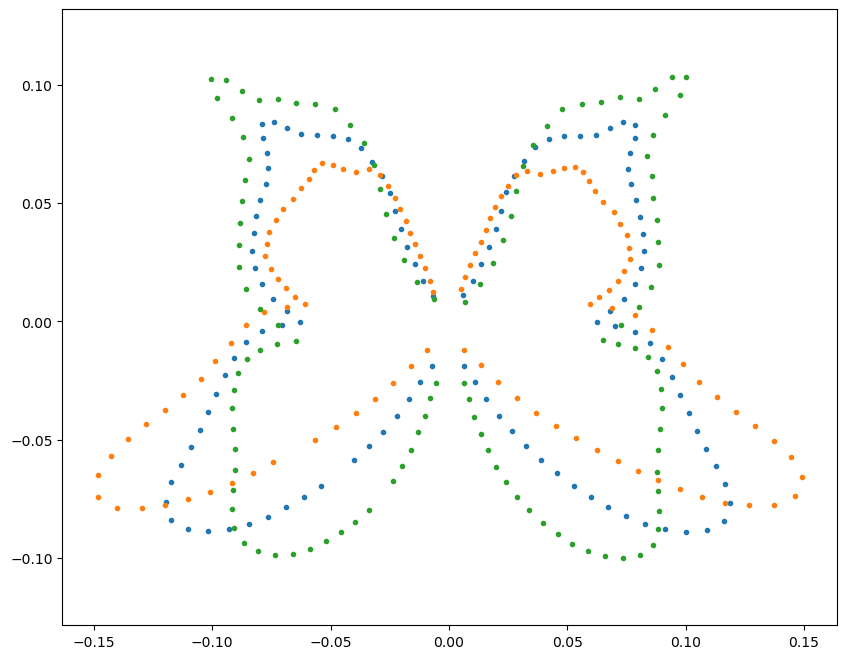

In [44]:
# Shift root node in direction of PC1
if filename.__contains__('papilio'):
    a_pc1_pos = a + 10 * np.sqrt(Sp[0])*Up[:,0] 
    a_pc1_neg = a - 10 * np.sqrt(Sp[0])*Up[:,0] 
else:
    a_pc1_pos = a + 0.8 * np.sqrt(Sp[0])*Up[:,0] 
    a_pc1_neg = a - 0.8 * np.sqrt(Sp[0])*Up[:,0] 


fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(a,ax=ax) #blue - PC1
plot_shape_2d(a_pc1_pos,ax=ax) #orange - in positive direction
plot_shape_2d(a_pc1_neg,ax=ax) #green - in negative direction


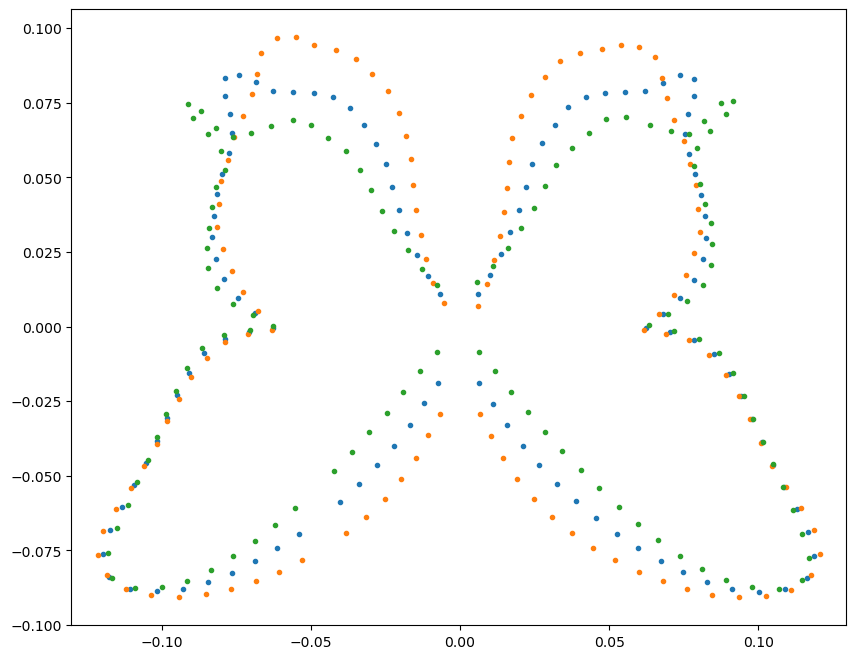

In [45]:
# Shift in direction of PC2
if filename.__contains__('papilio'):
    a_pc2_pos = a + 10 * np.sqrt(Sp[1])*Up[:,1] 
    a_pc2_neg = a - 10 * np.sqrt(Sp[1])*Up[:,1] 
else:
    a_pc2_pos = a + 0.8 * np.sqrt(Sp[1])*Up[:,1] 
    a_pc2_neg = a - 0.8 * np.sqrt(Sp[1])*Up[:,1] 

fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(a,ax=ax) 
plot_shape_2d(a_pc2_pos,ax=ax)
plot_shape_2d(a_pc2_neg,ax=ax)


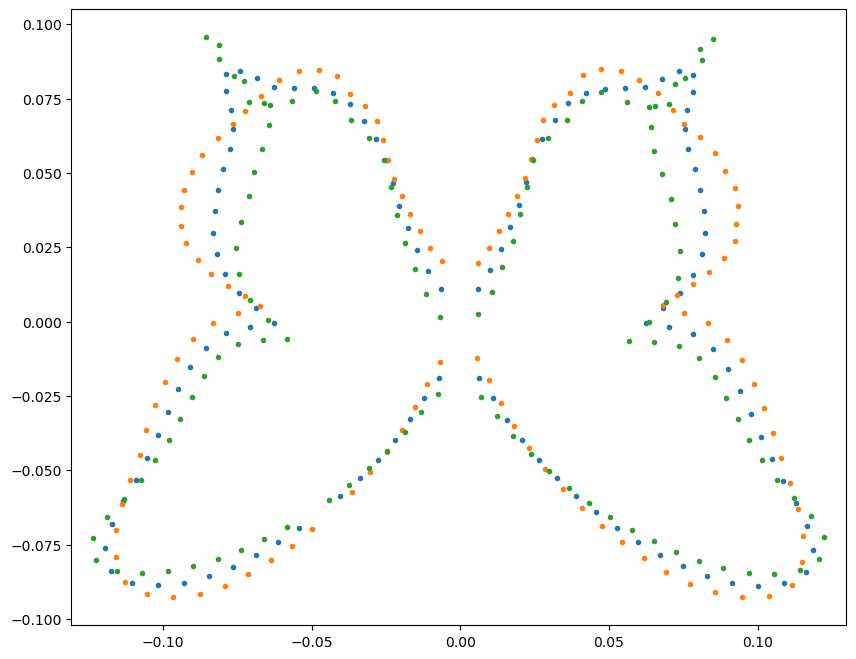

In [46]:
# Shift in direction of PC3

if filename.__contains__('papilio'):
    a_pc3_pos = a + 10 * np.sqrt(Sp[2])*Up[:,2] 
    a_pc3_neg = a - 10 * np.sqrt(Sp[2])*Up[:,2] 
else:
    a_pc3_pos = a + 0.8 * np.sqrt(Sp[2])*Up[:,2] 
    a_pc3_neg = a - 0.8 * np.sqrt(Sp[2])*Up[:,2] 

fig,ax = plt.subplots(figsize=(10,8))
plot_shape_2d(a,ax=ax)
plot_shape_2d(a_pc3_pos,ax=ax)
plot_shape_2d(a_pc3_neg,ax=ax)

# Export tree with phylogenetic PCA scores with Pickle

In [47]:
if filename.__contains__('papilio'):
    with open("small_tree.pkl", "wb") as f:
        pickle.dump(tree, f)
else:
    with open("big_tree.pkl", "wb") as f:
        pickle.dump(tree, f)